# LLM-as-a-Judge: ICL vs Baseline Results Evaluation

In [1]:

import os
import sys
import json
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import time
import subprocess
from dotenv import load_dotenv
import google.generativeai as genai
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

# Add project directory to path for imports
sys.path.append('..')

# Load environment variables
load_dotenv()

# Configure Google Generative AI
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

## Data Loading and Preprocessing

In [3]:
# Create results directory for evaluations
eval_results_dir = Path("../Results/Evaluations")
eval_results_dir.mkdir(parents=True, exist_ok=True)

# Load baseline results
print("Loading baseline results...")
baseline_results_file = Path("../Results/Baseline_Gemma3/baseline_results.parquet")
if baseline_results_file.exists():
    baseline_df = pd.read_parquet(baseline_results_file)
    print(f"Loaded {len(baseline_df)} baseline results")
else:
    raise FileNotFoundError(f"Could not find baseline results at {baseline_results_file}")

Loading baseline results...
Loaded 62 baseline results


In [4]:
# Load ICL results with better error handling
print("\nLoading ICL results...")
icl_results_file = Path("../Results/ICL_Gemma3/icl_results.parquet")
if not icl_results_file.exists():
    # Try to compile from individual results
    print("Parquet file not found, attempting to compile from individual JSON files...")
    icl_json_files = list(Path("../Results/ICL_Gemma3").glob("*_icl.json"))
    if not icl_json_files:
        raise FileNotFoundError(f"No ICL result files found in ../Results/ICL_Gemma3/")
    
    print(f"Found {len(icl_json_files)} individual ICL result files")
    icl_results = []
    valid_results_count = 0
    error_count = 0
    
    for file in icl_json_files:
        try:
            with open(file, 'r') as f:
                result = json.load(f)
                if result is not None:  # Check if result is valid
                    icl_results.append(result)
                    valid_results_count += 1
                else:
                    print(f"Warning: File {file.name} contains None result")
                    error_count += 1
        except json.JSONDecodeError:
            print(f"Warning: Could not decode JSON from file {file.name}")
            error_count += 1
        except Exception as e:
            print(f"Error processing {file.name}: {str(e)}")
            error_count += 1
    
    print(f"Successfully loaded {valid_results_count} valid results")
    if error_count > 0:
        print(f"Encountered {error_count} files with errors")
    
    if not icl_results:
        raise ValueError("No valid ICL results were found")
    
    # Create DataFrame from valid results only
    icl_df = pd.DataFrame(icl_results)
    icl_df.to_parquet(icl_results_file)
    print(f"Compiled {len(icl_df)} ICL results and saved to {icl_results_file}")
else:
    icl_df = pd.read_parquet(icl_results_file)
    print(f"Loaded {len(icl_df)} ICL results")


Loading ICL results...
Parquet file not found, attempting to compile from individual JSON files...
Found 48 individual ICL result files
Successfully loaded 44 valid results
Encountered 4 files with errors
Compiled 44 ICL results and saved to ../Results/ICL_Gemma3/icl_results.parquet


In [5]:
# Load original test dataset with ground truth solutions
print("\nLoading test dataset with ground truth solutions...")
test_file = Path("../Data/GeneratedCases/test_cases.parquet")
if test_file.exists():
    test_df = pd.read_parquet(test_file)
    print(f"Loaded {len(test_df)} test cases with ground truth solutions")
else:
    raise FileNotFoundError(f"Could not find test cases at {test_file}")


Loading test dataset with ground truth solutions...
Loaded 62 test cases with ground truth solutions


In [6]:
# Create comparison dataset with only cases that have both baseline and ICL solutions
print("\nCreating comparison dataset...")
# Get case IDs that exist in both baseline and ICL results
common_case_ids = set(baseline_df['case_id']).intersection(set(icl_df['case_id']))
print(f"Found {len(common_case_ids)} cases with both baseline and ICL solutions")

# Filter dataframes to only include common cases
baseline_filtered = baseline_df[baseline_df['case_id'].isin(common_case_ids)]
icl_filtered = icl_df[icl_df['case_id'].isin(common_case_ids)]




Creating comparison dataset...
Found 44 cases with both baseline and ICL solutions


In [7]:
# Create evaluation dataset
eval_data = []
for case_id in common_case_ids:
    try:
        # Get baseline solution
        baseline_row = baseline_filtered[baseline_filtered['case_id'] == case_id].iloc[0]
        
        # Get ICL solution
        icl_row = icl_filtered[icl_filtered['case_id'] == case_id].iloc[0]
        
        # Get ground truth solution
        gt_row = test_df[test_df['case_id'] == case_id]
        if len(gt_row) == 0:
            print(f"Warning: Could not find ground truth for case {case_id}")
            continue
        gt_row = gt_row.iloc[0]
        
        # Add to evaluation dataset
        eval_data.append({
            'case_id': case_id,
            'title': baseline_row['title'],
            'scenario_description': gt_row['enhanced_case'],
            'baseline_solution': baseline_row['solution'],
            'icl_solution': icl_row['solution'],
            'groundtruth_solution': gt_row['solution'],
            'examples_used': icl_row.get('examples_used', [])
        })
    except Exception as e:
        print(f"Error processing case {case_id}: {str(e)}")

# Convert to DataFrame
eval_df = pd.DataFrame(eval_data)
print(f"Created evaluation dataset with {len(eval_df)} cases")

# Save the evaluation dataset for future use
eval_dataset_file = eval_results_dir / "evaluation_dataset.parquet"
eval_df.to_parquet(eval_dataset_file)
print(f"Saved evaluation dataset to {eval_dataset_file}")

Created evaluation dataset with 44 cases
Saved evaluation dataset to ../Results/Evaluations/evaluation_dataset.parquet


In [8]:
eval_df.head()

,case_id,title,scenario_description,baseline_solution,icl_solution,groundtruth_solution,examples_used
0,case-20250329-090028-g83pyl,**Baltic Breeze: Navigating Seafood Import Cha...,"**Scenario:** Baltic Breeze Seafood, a growing...",## Baltic Breeze: Solution to Seafood Import C...,## Executive Summary\n\nBaltic Breeze Seafood ...,## Executive Summary Baltic Breeze Seafood is ...,"[{'case_id': 'case-20250329-003424-5mehzg', 't..."
1,case-20250329-001020-t32sit,Arctic Ice Trap: Navigating Regulatory Risks i...,"**Scenario:** Northern Lights Shipping, a medi...",## Arctic Ice Trap: Solution for Northern Ligh...,## Arctic Ice Trap: Navigating Regulatory Risk...,## Executive Summary Northern Lights Shipping ...,"[{'case_id': 'case-20250329-085445-ket25l', 't..."
2,case-20250329-001222-kqjau3,The Baltic Bottleneck: Navigating Congestion a...,"**Scenario:** OceanWave Logistics, a rapidly g...",## Solution for OceanWave Logistics: Navigatin...,## Executive Summary: The Baltic Bottleneck - ...,## Executive Summary OceanWave Logistics is fa...,"[{'case_id': 'case-20250329-004923-xsvmly', 't..."
3,case-20250329-082454-w9yo73,Gdansk Gridlock: Nordic SeaLines Struggle for ...,**Case Title: Gdansk Gridlock: Nordic SeaLines...,## Nordic SeaLines: Gdansk Gridlock - Strategi...,## Executive Summary: Gdansk Gridlock - Nordic...,## Executive Summary Nordic SeaLines faces a s...,"[{'case_id': 'case-20250329-084917-8bk49j', 't..."
4,case-20250330-081631-9ahbtr,**Baltic Squeeze: Navigating Congestion and Su...,**Case Study: Baltic Squeeze: Navigating Conge...,## Baltic Breeze Seafoods: Solution - Navigati...,## Executive Summary\n\nBaltic Breeze Seafoods...,## Executive Summary Baltic Breeze Seafoods (B...,"[{'case_id': 'case-20250329-211618-gtq7vw', 't..."


## Evaluation Framework Setup

In [9]:
# Set up the model for evaluation
def setup_evaluation_model():
    """Set up the Gemini model for evaluation"""
    print("\nSetting up Gemini 2.5 Pro Exp model for evaluation...")
    
    try:
        model_name = "gemini-2.5-pro-exp-03-25"
        model = genai.GenerativeModel(model_name=model_name)
        test_response = model.generate_content("Test")
        print(f"✅ Model {model_name} is available and working")
        return model_name
    except Exception as e:
        print(f"⚠️ Could not access experimental model. Error: {str(e)}")
        print("Falling back to standard model...")
        
        model_name = "gemini-2.0-flash"
        model = genai.GenerativeModel(model_name=model_name)
        test_response = model.generate_content("Test")
        print(f"✅ Fallback model {model_name} is available and working")
        return model_name

In [13]:
# Create evaluation prompt function with 10-point scale
def create_evaluation_prompt(scenario, assistant_answer, groundtruth_answer):
    """Create an evaluation prompt for the LLM judge using a 10-point scale"""
    
    prompt = f"""
**Role:** You are an expert evaluator assessing the quality of responses generated by an AI Assistant tasked with solving a business case in SCM Logistics.

**Task:** Evaluate the provided `assistant_answer` based on the `scenario_description` and compare its reasoning against the `groundtruth_answer`. Focus your quantitative scoring on the quality of the Assistant's reasoning process.

**Core Principles:**
*   **Objectivity:** Base your evaluation solely on the provided texts.
*   **Scenario-Fact Adherence:** Verify reasoning against facts stated ONLY within the `scenario_description`. Do not use external knowledge.
*   **Context Limitation:** Your evaluation must be confined to the `scenario_description`, `assistant_answer`, and `groundtruth_answer`.

**Inputs:**
1.  `scenario_description`: {scenario}
2.  `assistant_answer`: {assistant_answer}
3.  `groundtruth_answer`: {groundtruth_answer}

**Evaluation Steps & Required Output:**

1.  **Analyze Interpretation:** Briefly assess if the Assistant understood the core problem in the `scenario_description`. (This informs context but is not directly scored in the final output).
2.  **Analyze Reasoning Quality:** Carefully examine the Assistant's reasoning steps (e.g., Chain-of-Thought). Evaluate the following aspects and provide a score from 1 (Poor) to 10 (Excellent) for each:
    *   **`reasoning_logical_soundness` (Score 1-10):** How logically coherent and internally consistent is the reasoning? Do steps follow plausibly from each other and the scenario facts (as interpreted by the assistant)? Are there major logical flaws or contradictions?
    *   **`reasoning_explanatory_quality` (Score 1-10):** How clearly and convincingly does the Assistant explain *why* it reaches certain conclusions or takes certain steps, based on the scenario? Is the causal link between analysis and conclusion clear?
    *   **`reasoning_structure_clarity` (Score 1-10):** How well-organized, structured, and easy to follow is the reasoning? Is the language clear?
3.  **Analyze Solution Relevance:** Briefly assess if the final solution/recommendation addresses the core issue in the `scenario_description` and aligns directionally with the `groundtruth_answer`. (This informs context but is not directly scored in the final output).
4.  **Generate Evaluation Report (JSON Format):** Output a JSON object containing:
    *   `evaluation_summary`: (String) A concise 1-2 sentence overall assessment of the assistant's performance, focusing on reasoning quality.
    *   `scores`: (Object) Containing the integer scores (1-10) for the three specific metrics:
        *   `reasoning_logical_soundness`: [Score 1-10]
        *   `reasoning_explanatory_quality`: [Score 1-10]
        *   `reasoning_structure_clarity`: [Score 1-10]
    *   `strengths`: (List of strings) Specific positive aspects observed, particularly regarding the scored reasoning criteria.
    *   `weaknesses`: (List of strings) Specific negative aspects or errors observed, particularly regarding the scored reasoning criteria, providing brief justification for lower scores.

Be precise and critical in your evaluation. Make use of the full 1-10 scale to differentiate quality levels. A score of 10 should be reserved for truly exceptional work, while 5 represents an average performance.

Please provide your evaluation in the exact JSON format specified above. Your output must be valid JSON that can be parsed.
"""
    return prompt

In [11]:
# Function to evaluate a single case with either baseline or ICL solution
def evaluate_solution(scenario, solution, groundtruth, model_name):
    """Evaluate a solution using the LLM judge"""
    try:
        prompt = create_evaluation_prompt(scenario, solution, groundtruth)
        model = genai.GenerativeModel(model_name=model_name)
        response = model.generate_content(
            prompt,
            generation_config=genai.types.GenerationConfig(
                temperature=0.1,  # Low temperature for consistent evaluation
                response_mime_type="application/json"  # Request JSON output
            )
        )
        
        # Parse the JSON response
        try:
            evaluation = json.loads(response.text)
            return evaluation
        except json.JSONDecodeError:
            print("Error parsing JSON response. Raw response:")
            print(response.text)
            return {
                "evaluation_summary": "Error parsing evaluation",
                "scores": {
                    "reasoning_logical_soundness": 0,
                    "reasoning_explanatory_quality": 0,
                    "reasoning_structure_clarity": 0
                },
                "strengths": ["Error in evaluation"],
                "weaknesses": ["Could not parse evaluation result"]
            }
            
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        return None

## Test Evaluation Code for a Single Case

In [12]:
# Set up the evaluation model
evaluation_model = setup_evaluation_model()

# Start caffeinate to prevent Mac from sleeping
print("\nStarting caffeinate for evaluation process...")
caffeinate_process = subprocess.Popen(["caffeinate", "-i", "-d", "-m"], 
                                    stdout=subprocess.DEVNULL, 
                                    stderr=subprocess.DEVNULL)

# Run evaluation on a single test case
try:
    print("\nRunning evaluation on a single test case")
    evaluation_results = []
    
    # Get the first case for testing
    test_row = eval_df.iloc[0]
    case_id = test_row['case_id']
    title = test_row['title']
    scenario = test_row['scenario_description']
    baseline_solution = test_row['baseline_solution']
    icl_solution = test_row['icl_solution']
    groundtruth_solution = test_row['groundtruth_solution']
    
    print(f"\nEvaluating test case: {title}")
    
    # Evaluate baseline solution
    print("Evaluating baseline solution...")
    baseline_eval = evaluate_solution(
        scenario, 
        baseline_solution, 
        groundtruth_solution, 
        evaluation_model
    )
    print("Baseline evaluation complete.")
    print(f"Baseline scores: {baseline_eval['scores'] if baseline_eval else 'Error'}")
    
    # Add 10-second delay as requested
    print("Waiting 10 seconds before ICL evaluation...")
    time.sleep(10)
    
    # Evaluate ICL solution
    print("Evaluating ICL solution...")
    icl_eval = evaluate_solution(
        scenario, 
        icl_solution, 
        groundtruth_solution, 
        evaluation_model
    )
    print("ICL evaluation complete.")
    print(f"ICL scores: {icl_eval['scores'] if icl_eval else 'Error'}")
    
    # Compile results
    result = {
        'case_id': case_id,
        'title': title,
        'baseline_evaluation': baseline_eval,
        'icl_evaluation': icl_eval,
        'examples_used': test_row['examples_used']
    }
    
    # Save individual result
    result_file = eval_results_dir / f"{case_id}_evaluation_test.json"
    with open(result_file, 'w') as f:
        json.dump(result, f, indent=2)
    
    evaluation_results.append(result)
    print(f"\n✅ Test evaluation for case {case_id} completed and saved to {result_file}")
    
    # Create test results DataFrame
    test_results_df = pd.DataFrame(evaluation_results)
    test_results_df.to_parquet(eval_results_dir / "evaluation_test_result.parquet")
    
    # Display comparison
    if baseline_eval and icl_eval:
        print("\nComparison of baseline vs ICL for test case:")
        comparison = {
            "Category": ["Logical Soundness", "Explanatory Quality", "Structure Clarity", "Average"],
            "Baseline": [
                baseline_eval['scores']['reasoning_logical_soundness'],
                baseline_eval['scores']['reasoning_explanatory_quality'],
                baseline_eval['scores']['reasoning_structure_clarity'],
                sum(baseline_eval['scores'].values()) / 3
            ],
            "ICL": [
                icl_eval['scores']['reasoning_logical_soundness'],
                icl_eval['scores']['reasoning_explanatory_quality'],
                icl_eval['scores']['reasoning_structure_clarity'],
                sum(icl_eval['scores'].values()) / 3
            ]
        }
        display(pd.DataFrame(comparison).set_index("Category"))

finally:
    # Terminate caffeinate
    print("Terminating caffeinate...")
    caffeinate_process.terminate()


Setting up Gemini 2.5 Pro Exp model for evaluation...
✅ Model gemini-2.5-pro-exp-03-25 is available and working

Starting caffeinate for evaluation process...

Running evaluation on a single test case

Evaluating test case: **Baltic Breeze: Navigating Seafood Import Challenges and EU Regulatory Compliance**
Evaluating baseline solution...
Baseline evaluation complete.
Baseline scores: {'reasoning_logical_soundness': 5, 'reasoning_explanatory_quality': 4, 'reasoning_structure_clarity': 5}
Waiting 10 seconds before ICL evaluation...
Evaluating ICL solution...
ICL evaluation complete.
ICL scores: {'reasoning_logical_soundness': 5, 'reasoning_explanatory_quality': 5, 'reasoning_structure_clarity': 5}

✅ Test evaluation for case case-20250329-090028-g83pyl completed and saved to ../Results/Evaluations/case-20250329-090028-g83pyl_evaluation_test.json

Comparison of baseline vs ICL for test case:


,Baseline,ICL
Category,,
Logical Soundness,5.000000,5.0
Explanatory Quality,4.000000,5.0
Structure Clarity,5.000000,5.0
Average,4.666667,5.0


Terminating caffeinate...


## Evaluation Execution


In [14]:
# Set up the evaluation model
evaluation_model = setup_evaluation_model()

# Start caffeinate to prevent Mac from sleeping
print("\nStarting caffeinate for evaluation process...")
caffeinate_process = subprocess.Popen(["caffeinate", "-i", "-d", "-m"], 
                                    stdout=subprocess.DEVNULL, 
                                    stderr=subprocess.DEVNULL)

# Run evaluations
try:
    print(f"\nRunning evaluations on {len(eval_df)} cases...")
    evaluation_results = []
    
    # Set the number of cases to evaluate (set to a small number for initial testing)
    max_cases = len(eval_df)  # Change to a smaller number for testing
    
    for i, row in tqdm(eval_df.head(max_cases).iterrows(), total=min(max_cases, len(eval_df))):
        case_id = row['case_id']
        title = row['title']
        scenario = row['scenario_description']
        baseline_solution = row['baseline_solution']
        icl_solution = row['icl_solution']
        groundtruth_solution = row['groundtruth_solution']
        
        print(f"\nEvaluating case {i+1}/{max_cases}: {title}")
        
        # Evaluate baseline solution
        print("Evaluating baseline solution...")
        baseline_eval = evaluate_solution(
            scenario, 
            baseline_solution, 
            groundtruth_solution, 
            evaluation_model
        )
        
        # Add 10-second delay as requested
        time.sleep(10)
        
        # Evaluate ICL solution
        print("Evaluating ICL solution...")
        icl_eval = evaluate_solution(
            scenario, 
            icl_solution, 
            groundtruth_solution, 
            evaluation_model
        )
        
        # Compile results
        result = {
            'case_id': case_id,
            'title': title,
            'baseline_evaluation': baseline_eval,
            'icl_evaluation': icl_eval,
            'examples_used': row['examples_used']
        }
        
        # Save individual result
        result_file = eval_results_dir / f"{case_id}_evaluation.json"
        with open(result_file, 'w') as f:
            json.dump(result, f, indent=2)
            
        evaluation_results.append(result)
        print(f"✅ Evaluation for case {case_id} completed and saved")
        
        # Add 10-second delay between cases
        if i < min(max_cases, len(eval_df)) - 1:
            time.sleep(10)
    
    # Compile all results
    all_results_file = eval_results_dir / "all_evaluation_results.json"
    with open(all_results_file, 'w') as f:
        json.dump(evaluation_results, f, indent=2)
    
    # Create results DataFrame
    results_df = pd.DataFrame(evaluation_results)
    results_df.to_parquet(eval_results_dir / "evaluation_results.parquet")
    
    print(f"\n✅ Completed evaluations for {len(evaluation_results)} cases")
    print(f"Results saved to {eval_results_dir}")

finally:
    # Terminate caffeinate
    print("Terminating caffeinate...")
    caffeinate_process.terminate()


Setting up Gemini 2.5 Pro Exp model for evaluation...
✅ Model gemini-2.5-pro-exp-03-25 is available and working

Starting caffeinate for evaluation process...

Running evaluations on 44 cases...


  0%|          | 0/44 [00:00<?, ?it/s]


Evaluating case 1/44: **Baltic Breeze: Navigating Seafood Import Challenges and EU Regulatory Compliance**
Evaluating baseline solution...
Evaluating ICL solution...
✅ Evaluation for case case-20250329-090028-g83pyl completed and saved

Evaluating case 2/44: Arctic Ice Trap: Navigating Regulatory Risks in the Northern Sea Route
Evaluating baseline solution...
Evaluating ICL solution...
✅ Evaluation for case case-20250329-001020-t32sit completed and saved

Evaluating case 3/44: The Baltic Bottleneck: Navigating Congestion and Compliance at OceanWave Logistics
Evaluating baseline solution...
Evaluating ICL solution...
✅ Evaluation for case case-20250329-001222-kqjau3 completed and saved

Evaluating case 4/44: Gdansk Gridlock: Nordic SeaLines Struggle for Baltic Supremacy
Evaluating baseline solution...
Evaluating ICL solution...
✅ Evaluation for case case-20250329-082454-w9yo73 completed and saved

Evaluating case 5/44: **Baltic Squeeze: Navigating Congestion and Surcharges in Seafood E

In [16]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   case_id              44 non-null     object
 1   title                44 non-null     object
 2   baseline_evaluation  44 non-null     object
 3   icl_evaluation       44 non-null     object
 4   examples_used        44 non-null     object
dtypes: object(5)
memory usage: 1.8+ KB


## Results Analysis and Visualization


In [19]:
# Update visualization code with fixed data type handling
def analyze_results(results_df):
    """Analyze and visualize evaluation results with 10-point scale and improved debugging"""
    print("Starting analysis of evaluation results...")
    print(f"Processing {len(results_df)} evaluation results")
    
    # Extract scores from evaluation results
    baseline_scores = []
    icl_scores = []
    error_count = 0
    
    for idx, row in results_df.iterrows():
        try:
            # Get evaluations
            baseline_eval = row['baseline_evaluation']
            icl_eval = row['icl_evaluation']
            
            # Skip if either evaluation failed
            if baseline_eval is None or icl_eval is None:
                print(f"Skipping row {idx}: Missing evaluation")
                error_count += 1
                continue
            
            # Verify scores exist
            if 'scores' not in baseline_eval or 'scores' not in icl_eval:
                print(f"Skipping row {idx}: Missing scores structure")
                error_count += 1
                continue
                
            # Append baseline scores - explicitly convert to float
            baseline_scores.append({
                'case_id': row['case_id'],
                'method': 'Baseline',
                'logical_soundness': float(baseline_eval['scores']['reasoning_logical_soundness']),
                'explanatory_quality': float(baseline_eval['scores']['reasoning_explanatory_quality']),
                'structure_clarity': float(baseline_eval['scores']['reasoning_structure_clarity']),
                'average_score': (
                    float(baseline_eval['scores']['reasoning_logical_soundness']) +
                    float(baseline_eval['scores']['reasoning_explanatory_quality']) +
                    float(baseline_eval['scores']['reasoning_structure_clarity'])
                ) / 3.0
            })
            
            # Append ICL scores - explicitly convert to float
            icl_scores.append({
                'case_id': row['case_id'],
                'method': 'ICL',
                'logical_soundness': float(icl_eval['scores']['reasoning_logical_soundness']),
                'explanatory_quality': float(icl_eval['scores']['reasoning_explanatory_quality']),
                'structure_clarity': float(icl_eval['scores']['reasoning_structure_clarity']),
                'average_score': (
                    float(icl_eval['scores']['reasoning_logical_soundness']) +
                    float(icl_eval['scores']['reasoning_explanatory_quality']) +
                    float(icl_eval['scores']['reasoning_structure_clarity'])
                ) / 3.0
            })
        except Exception as e:
            print(f"Error processing row {idx} (Case ID: {row['case_id']}): {str(e)}")
            error_count += 1
    
    print(f"\nProcessed {len(baseline_scores)} baseline scores and {len(icl_scores)} ICL scores")
    if error_count > 0:
        print(f"Encountered {error_count} errors during processing")
    
    if not baseline_scores or not icl_scores:
        print("Error: No valid scores extracted. Cannot generate visualizations.")
        return None, None
    
    # Convert to DataFrame
    scores_df = pd.DataFrame(baseline_scores + icl_scores)
    
    # Debug information - check the DataFrame structure before groupby
    print("\nScores DataFrame info:")
    print(scores_df.info())
    print("\nScores DataFrame first few rows:")
    print(scores_df.head())
    
    # Calculate average scores with explicit numeric columns
    try:
        # Calculate means manually to avoid groupby issues
        baseline_means = scores_df[scores_df['method'] == 'Baseline'].mean(numeric_only=True)
        icl_means = scores_df[scores_df['method'] == 'ICL'].mean(numeric_only=True)
        
        # Create avg_scores DataFrame manually
        avg_scores = pd.DataFrame({
            'Baseline': baseline_means,
            'ICL': icl_means
        })
        
        print("\nAverage Scores:")
        display(avg_scores)
    except Exception as e:
        print(f"Error calculating means: {str(e)}")
        # Fallback to simple averaging
        print("\nFallback to simple averaging:")
        for method in ['Baseline', 'ICL']:
            filtered = scores_df[scores_df['method'] == method]
            print(f"\n{method} Averages:")
            print(f"Logical Soundness: {filtered['logical_soundness'].mean():.2f}")
            print(f"Explanatory Quality: {filtered['explanatory_quality'].mean():.2f}")
            print(f"Structure Clarity: {filtered['structure_clarity'].mean():.2f}")
            print(f"Overall Average: {filtered['average_score'].mean():.2f}")
    
    # Create comparison plots
    plt.figure(figsize=(12, 8))
    
    # Plot average scores comparison
    plt.subplot(2, 2, 1)
    sns.barplot(x='method', y='average_score', data=scores_df)
    plt.title('Average Score Comparison')
    plt.ylim(0, 10)  # Updated for 10-point scale
    
    # Plot logical soundness comparison
    plt.subplot(2, 2, 2)
    sns.barplot(x='method', y='logical_soundness', data=scores_df)
    plt.title('Logical Soundness Comparison')
    plt.ylim(0, 10)  # Updated for 10-point scale
    
    # Plot explanatory quality comparison
    plt.subplot(2, 2, 3)
    sns.barplot(x='method', y='explanatory_quality', data=scores_df)
    plt.title('Explanatory Quality Comparison')
    plt.ylim(0, 10)  # Updated for 10-point scale
    
    # Plot structure clarity comparison
    plt.subplot(2, 2, 4)
    sns.barplot(x='method', y='structure_clarity', data=scores_df)
    plt.title('Structure Clarity Comparison')
    plt.ylim(0, 10)  # Updated for 10-point scale
    
    plt.tight_layout()
    plt.savefig(eval_results_dir / 'score_comparison.png', dpi=300)
    plt.show()
    
    # Calculate and display win rates
    win_data = []
    for case_id in scores_df['case_id'].unique():
        baseline = scores_df[(scores_df['case_id'] == case_id) & (scores_df['method'] == 'Baseline')]['average_score'].values[0]
        icl = scores_df[(scores_df['case_id'] == case_id) & (scores_df['method'] == 'ICL')]['average_score'].values[0]
        
        winner = "ICL" if icl > baseline else "Baseline" if baseline > icl else "Tie"
        win_data.append({
            'case_id': case_id,
            'baseline_score': baseline,
            'icl_score': icl,
            'difference': icl - baseline,
            'winner': winner
        })
    
    win_df = pd.DataFrame(win_data)
    win_counts = win_df['winner'].value_counts()
    win_percentages = (win_counts / len(win_df)) * 100
    
    print("\nWin Percentages:")
    for method, percentage in win_percentages.items():
        print(f"{method}: {percentage:.2f}%")
    
    # Plot win percentages
    plt.figure(figsize=(8, 6))
    win_percentages.plot(kind='bar')
    plt.title('Win Percentages')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=0)
    plt.savefig(eval_results_dir / 'win_percentages.png', dpi=300)
    plt.show()
    
    return scores_df, win_df

Calling analyze_results function with the evaluation results...
Starting analysis of evaluation results...
Processing 44 evaluation results

Processed 44 baseline scores and 44 ICL scores

Scores DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   case_id              88 non-null     object 
 1   method               88 non-null     object 
 2   logical_soundness    88 non-null     float64
 3   explanatory_quality  88 non-null     float64
 4   structure_clarity    88 non-null     float64
 5   average_score        88 non-null     float64
dtypes: float64(4), object(2)
memory usage: 4.3+ KB
None

Scores DataFrame first few rows:
                       case_id    method  logical_soundness  \
0  case-20250329-090028-g83pyl  Baseline                9.0   
1  case-20250329-001020-t32sit  Baseline                8.0   
2  cas

,Baseline,ICL
logical_soundness,8.295455,8.454545
explanatory_quality,7.204545,8.431818
structure_clarity,9.295455,9.545455
average_score,8.265152,8.810606


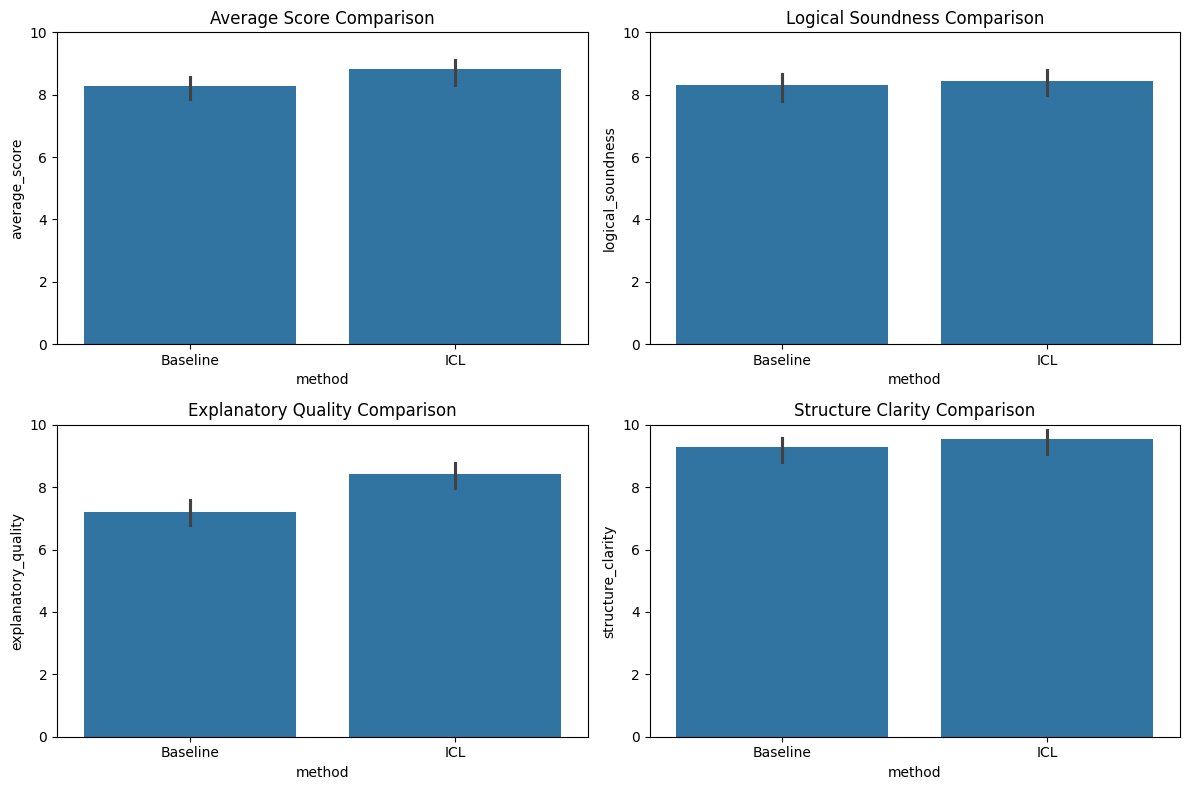


Win Percentages:
ICL: 68.18%
Tie: 22.73%
Baseline: 9.09%


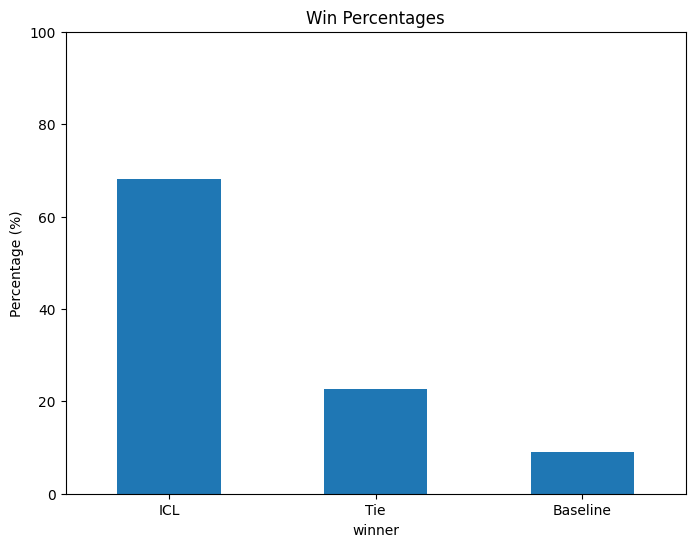

Analysis complete.


In [20]:
# Code to test the function with our data
print("Calling analyze_results function with the evaluation results...")
scores_df, _ = analyze_results(results_df)
print("Analysis complete.")

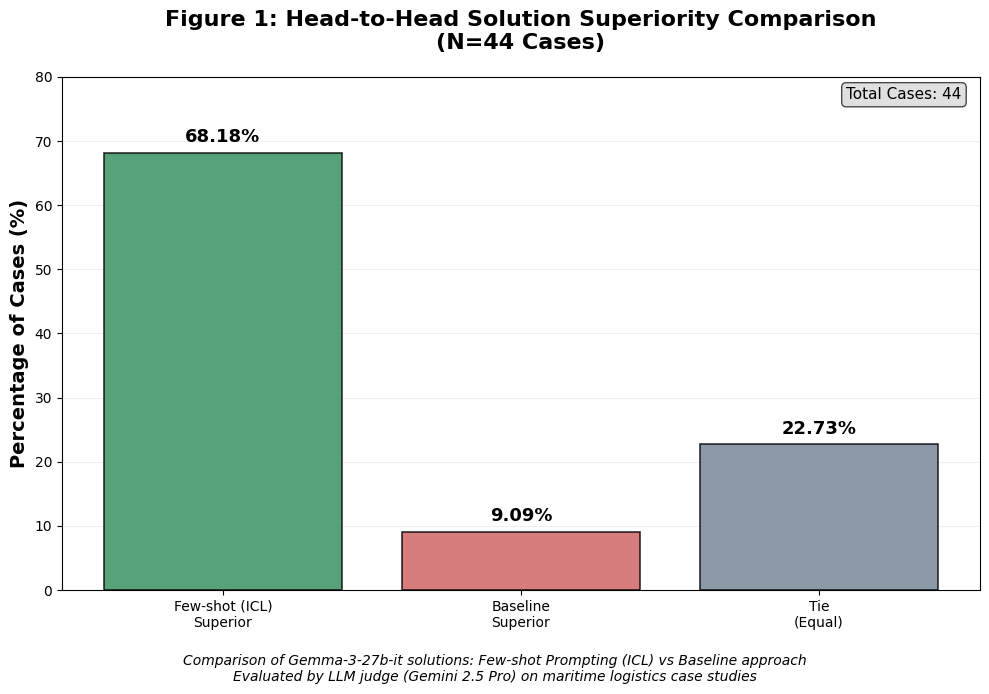

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your ICL vs Baseline Analysis Report
few_shot_wins = 68.18  # ICL approach superior
baseline_wins = 9.09   # Baseline approach superior  
ties = 22.73           # Equal performance

# Create the data
categories = ['Few-shot (ICL)\nSuperior', 'Baseline\nSuperior', 'Tie\n(Equal)']
percentages = [few_shot_wins, baseline_wins, ties]
colors = ['#2E8B57', '#CD5C5C', '#708090']  # Sea green, Indian red, Slate gray

# Create the figure
fig, ax = plt.subplots(figsize=(10, 7))

# Create the bar chart
bars = ax.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# Customize the plot
ax.set_ylabel('Percentage of Cases (%)', fontsize=14, fontweight='bold')
ax.set_title('Figure 1: Head-to-Head Solution Superiority Comparison\n(N=44 Cases)', 
             fontsize=16, fontweight='bold', pad=20)

# Set y-axis limits and ticks
ax.set_ylim(0, 80)
ax.set_yticks(np.arange(0, 81, 10))

# Add percentage labels on top of bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{percentage}%', ha='center', va='bottom', 
            fontsize=13, fontweight='bold')

# Add grid for better readability
ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Add subtitle with study details
plt.figtext(0.5, 0.02, 
           'Comparison of Gemma-3-27b-it solutions: Few-shot Prompting (ICL) vs Baseline approach\n' +
           'Evaluated by LLM judge (Gemini 2.5 Pro) on maritime logistics case studies',
           ha='center', fontsize=10, style='italic')

# Improve layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

# Add case count annotation
ax.text(0.98, 0.98, f'Total Cases: 44', transform=ax.transAxes, 
        ha='right', va='top', fontsize=11, 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))

# Display the plot
plt.show()

# Optional: Save the figure
# plt.savefig('Figure1_Head_to_Head_Comparison.png', dpi=300, bbox_inches='tight')

## AI generated Report based on Analysis Results

In [22]:
def generate_ai_analysis_report(scores_df, win_df, model_name="gemini-2.5-pro-exp-03-25"):
    """
    Generate a professional analysis report using a Gemini model
    
    Args:
        scores_df: DataFrame with all evaluation scores
        win_df: DataFrame with win/loss data
        model_name: Name of the Gemini model to use
    
    Returns:
        The generated report text
    """
    print("Generating professional analysis report...")
    
    # Create report directory if it doesn't exist
    docs_dir = Path("../Docs")
    docs_dir.mkdir(parents=True, exist_ok=True)
    
    # Calculate key statistics for the report
    baseline_avg = scores_df[scores_df['method'] == 'Baseline'].mean(numeric_only=True)
    icl_avg = scores_df[scores_df['method'] == 'ICL'].mean(numeric_only=True)
    win_counts = win_df['winner'].value_counts()
    win_percentages = (win_counts / len(win_df)) * 100
    
    # Calculate improvements
    improvements = {
        'logical_soundness': icl_avg['logical_soundness'] - baseline_avg['logical_soundness'],
        'explanatory_quality': icl_avg['explanatory_quality'] - baseline_avg['explanatory_quality'],
        'structure_clarity': icl_avg['structure_clarity'] - baseline_avg['structure_clarity'],
        'average_score': icl_avg['average_score'] - baseline_avg['average_score']
    }
    
    # Create properly formatted tables for the prompt
    # Scores table
    scores_table = f"""| Metric | Baseline | ICL | Improvement |
|--------|----------|-----|------------|
| Logical Soundness | {baseline_avg['logical_soundness']:.2f} | {icl_avg['logical_soundness']:.2f} | {improvements['logical_soundness']:.2f} |
| Explanatory Quality | {baseline_avg['explanatory_quality']:.2f} | {icl_avg['explanatory_quality']:.2f} | {improvements['explanatory_quality']:.2f} |
| Structure Clarity | {baseline_avg['structure_clarity']:.2f} | {icl_avg['structure_clarity']:.2f} | {improvements['structure_clarity']:.2f} |
| Average Score | {baseline_avg['average_score']:.2f} | {icl_avg['average_score']:.2f} | {improvements['average_score']:.2f} |"""

    # Win percentages table
    win_table = "| Method | Win % |\n|--------|-------|\n"
    for method, percentage in win_percentages.items():
        win_table += f"| {method} | {percentage:.2f}% |\n"
    
    # Prepare a prompt for the LLM
    prompt = f"""
# Results Analysis: In-Context Learning (ICL) vs. Baseline Approach

As an expert in AI and machine learning, please review the following results and write a professional 1000-word report on the effectiveness of In-Context Learning (ICL) compared to a baseline approach for solving maritime logistics case studies.

## Study Overview
We compared two approaches for solving maritime logistics case studies:
1. **Baseline Approach**: Using Gemma-3-27b-it without any special techniques
2. **ICL Approach**: Using Gemma-3-27b-it with In-Context Learning, providing similar cases as examples

## Evaluation Methodology
The solutions were evaluated using an independent LLM judge (Gemini 2.5 Pro) on a 10-point scale across three dimensions:
- **Reasoning Logical Soundness**: How logically coherent and internally consistent the reasoning is
- **Reasoning Explanatory Quality**: How clearly and convincingly the solution explains why it reaches certain conclusions
- **Reasoning Structure Clarity**: How well-organized, structured, and easy to follow the reasoning is

## Results Summary

### Average Scores (10-point scale)
{scores_table}

### Win Percentages
{win_table}

### Sample Size
- Total cases evaluated: {len(win_df)}
- ICL wins: {win_counts.get('ICL', 0)}
- Baseline wins: {win_counts.get('Baseline', 0)}
- Ties: {win_counts.get('Tie', 0)}

## Report Requirements
Please write a formal, professional report with the following sections:
1. **Executive Summary**: Brief overview of the study and key findings
2. **Introduction**: Context and purpose of comparing ICL vs baseline approaches
3. **Methodology**: How the models were set up and how evaluation was conducted
4. **Results Analysis**: Detailed analysis of the quantitative results
5. **Discussion**: Interpretation of findings, why ICL performs differently than baseline
6. **Limitations**: Any limitations of the study that should be considered
7. **Conclusion**: Overall assessment and recommendations for future work

Please use a formal academic tone, and include at least 1000 words.
"""
    
    try:
        # Generate the report using the specified model
        model = genai.GenerativeModel(model_name=model_name)
        response = model.generate_content(
            prompt,
            generation_config=genai.types.GenerationConfig(
                temperature=0.2,
                max_output_tokens=4096
            )
        )
        
        report_text = response.text
        
        # Create a filename with timestamp
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f"ICL_vs_Baseline_Analysis_Report_{timestamp}.md"
        filepath = docs_dir / filename
        
        # Save the report
        with open(filepath, "w") as f:
            f.write(report_text)
            
        print(f"Report successfully generated and saved to: {filepath}")
        return report_text
        
    except Exception as e:
        print(f"Error generating report: {str(e)}")
        return None

Calling analyze_results function with the evaluation results...
Starting analysis of evaluation results...
Processing 44 evaluation results

Processed 44 baseline scores and 44 ICL scores

Scores DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   case_id              88 non-null     object 
 1   method               88 non-null     object 
 2   logical_soundness    88 non-null     float64
 3   explanatory_quality  88 non-null     float64
 4   structure_clarity    88 non-null     float64
 5   average_score        88 non-null     float64
dtypes: float64(4), object(2)
memory usage: 4.3+ KB
None

Scores DataFrame first few rows:
                       case_id    method  logical_soundness  \
0  case-20250329-090028-g83pyl  Baseline                9.0   
1  case-20250329-001020-t32sit  Baseline                8.0   
2  cas

,Baseline,ICL
logical_soundness,8.295455,8.454545
explanatory_quality,7.204545,8.431818
structure_clarity,9.295455,9.545455
average_score,8.265152,8.810606


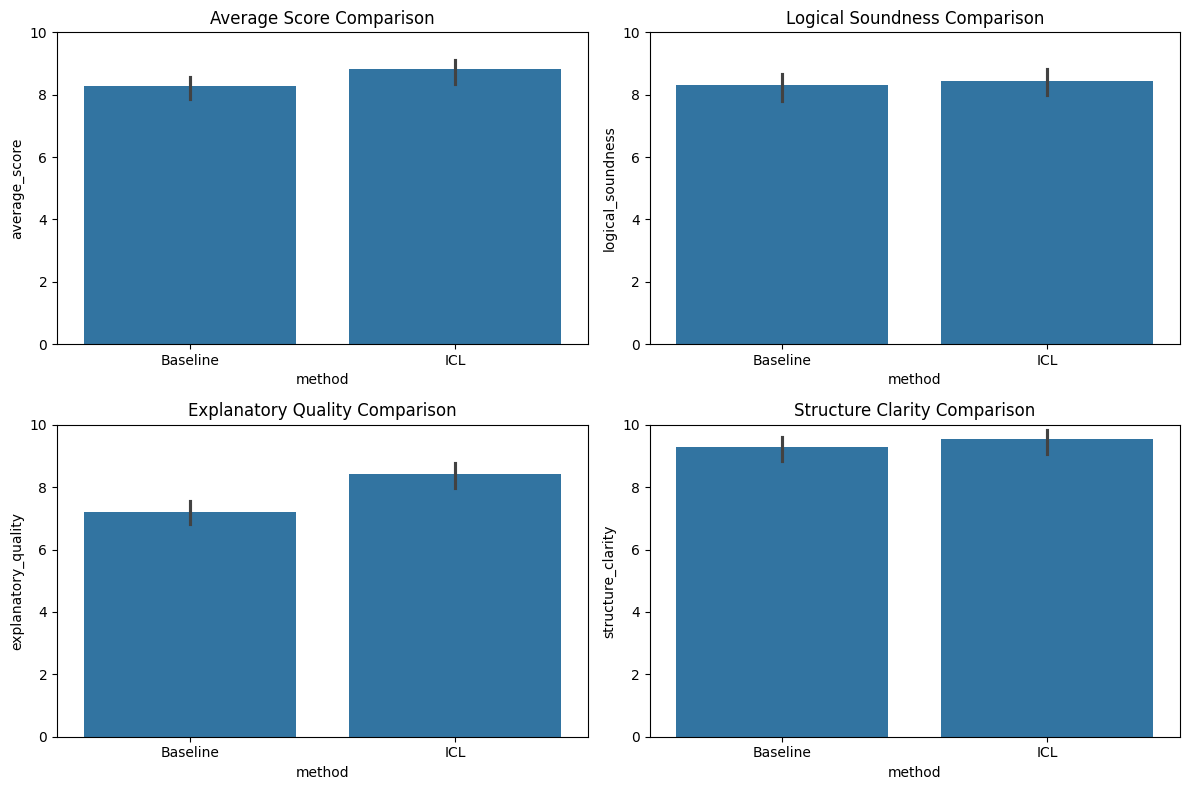


Win Percentages:
ICL: 68.18%
Tie: 22.73%
Baseline: 9.09%


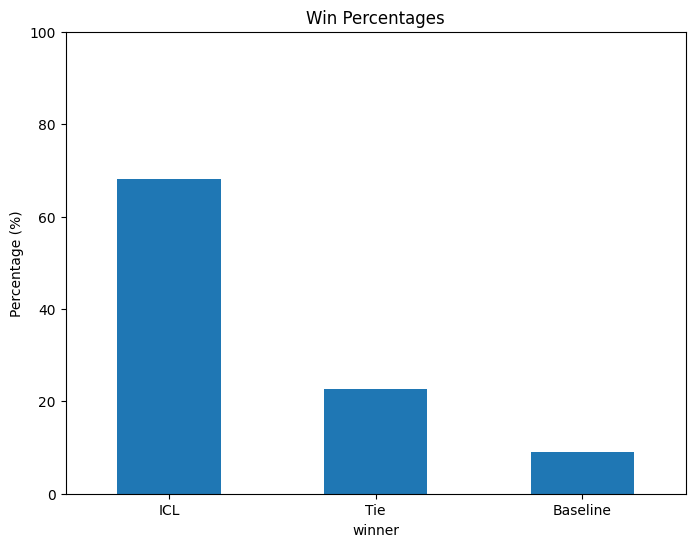

Analysis complete.


In [24]:
# Code to test the function with our data - fixed to capture both return values
print("Calling analyze_results function with the evaluation results...")
scores_df, win_df = analyze_results(results_df)  # Capture both return values
print("Analysis complete.")

In [25]:
# Generate AI analysis report and display preview
report = generate_ai_analysis_report(scores_df, win_df)
if report:
    # Display the beginning of the report
    print("\nReport Preview (first 500 characters):")
    print(report[:500] + "...")

Generating professional analysis report...
Report successfully generated and saved to: ../Docs/ICL_vs_Baseline_Analysis_Report_20250331-174257.md

Report Preview (first 500 characters):
Okay, here is a formal, 1000-word report analyzing the provided results on the effectiveness of In-Context Learning (ICL) compared to a baseline approach for maritime logistics case studies.

---

**Report: Comparative Analysis of In-Context Learning and Baseline Approaches for Maritime Logistics Case Study Resolution using Gemma-3-27b-it**

**Date:** October 26, 2023

**Prepared For:** Project Stakeholders

**Prepared By:** AI & Machine Learning Expert Analysis Unit

**Subject:** Evaluation of ...


# Annex

## Adding "Successfully Solved Cases" Metric

In [7]:
# Reload all necessary functions and data
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define paths
eval_results_dir = Path("../Results/Evaluations")

# Reload evaluation results from saved files
print("Loading evaluation results from saved files...")
results_file = eval_results_dir / "evaluation_results.parquet"

if results_file.exists():
    results_df = pd.read_parquet(results_file)
    print(f"Loaded {len(results_df)} evaluation results")
else:
    print(f"Could not find evaluation results at {results_file}")
    print("Trying to load from JSON...")
    json_file = eval_results_dir / "all_evaluation_results.json"
    if json_file.exists():
        with open(json_file, 'r') as f:
            evaluation_results = json.load(f)
        results_df = pd.DataFrame(evaluation_results)
        print(f"Loaded {len(results_df)} evaluation results from JSON")
    else:
        print(f"Could not find evaluation results JSON at {json_file}")



Loading evaluation results from saved files...
Loaded 44 evaluation results


In [8]:
def analyze_success_rates(scores_df, threshold=8.0):
    """Calculate the percentage of cases with scores above a threshold"""
    print(f"\nCalculating success rates (score >= {threshold})...")
    
    # Group by method and calculate success rates
    success_rates = {}
    
    for method in ['Baseline', 'ICL']:
        method_data = scores_df[scores_df['method'] == method]
        successful_cases = method_data[method_data['average_score'] >= threshold]
        success_rate = (len(successful_cases) / len(method_data)) * 100
        success_rates[method] = success_rate
        
    print(f"Baseline success rate: {success_rates['Baseline']:.2f}%")
    print(f"ICL success rate: {success_rates['ICL']:.2f}%")
    
    # Create a bar chart
    plt.figure(figsize=(8, 6))
    methods = list(success_rates.keys())
    rates = list(success_rates.values())
    
    plt.bar(methods, rates, color=['#1f77b4', '#ff7f0e'])
    plt.title(f'Percentage of Successfully Solved Cases (Score >= {threshold})')
    plt.ylabel('Success Rate (%)')
    plt.ylim(0, 100)
    plt.savefig(eval_results_dir / 'success_rates.png', dpi=300)
    plt.show()
    
    return success_rates

In [10]:
# Define analyze_results function
def analyze_results(results_df):
    """Analyze and visualize evaluation results with 10-point scale and improved debugging"""
    print("Starting analysis of evaluation results...")
    print(f"Processing {len(results_df)} evaluation results")
    
    # Extract scores from evaluation results
    baseline_scores = []
    icl_scores = []
    error_count = 0
    
    for idx, row in results_df.iterrows():
        try:
            # Get evaluations
            baseline_eval = row['baseline_evaluation']
            icl_eval = row['icl_evaluation']
            
            # Skip if either evaluation failed
            if baseline_eval is None or icl_eval is None:
                print(f"Skipping row {idx}: Missing evaluation")
                error_count += 1
                continue
            
            # Verify scores exist
            if 'scores' not in baseline_eval or 'scores' not in icl_eval:
                print(f"Skipping row {idx}: Missing scores structure")
                error_count += 1
                continue
                
            # Append baseline scores - explicitly convert to float
            baseline_scores.append({
                'case_id': row['case_id'],
                'method': 'Baseline',
                'logical_soundness': float(baseline_eval['scores']['reasoning_logical_soundness']),
                'explanatory_quality': float(baseline_eval['scores']['reasoning_explanatory_quality']),
                'structure_clarity': float(baseline_eval['scores']['reasoning_structure_clarity']),
                'average_score': (
                    float(baseline_eval['scores']['reasoning_logical_soundness']) +
                    float(baseline_eval['scores']['reasoning_explanatory_quality']) +
                    float(baseline_eval['scores']['reasoning_structure_clarity'])
                ) / 3.0
            })
            
            # Append ICL scores - explicitly convert to float
            icl_scores.append({
                'case_id': row['case_id'],
                'method': 'ICL',
                'logical_soundness': float(icl_eval['scores']['reasoning_logical_soundness']),
                'explanatory_quality': float(icl_eval['scores']['reasoning_explanatory_quality']),
                'structure_clarity': float(icl_eval['scores']['reasoning_structure_clarity']),
                'average_score': (
                    float(icl_eval['scores']['reasoning_logical_soundness']) +
                    float(icl_eval['scores']['reasoning_explanatory_quality']) +
                    float(icl_eval['scores']['reasoning_structure_clarity'])
                ) / 3.0
            })
        except Exception as e:
            print(f"Error processing row {idx} (Case ID: {row['case_id']}): {str(e)}")
            error_count += 1
    
    print(f"\nProcessed {len(baseline_scores)} baseline scores and {len(icl_scores)} ICL scores")
    if error_count > 0:
        print(f"Encountered {error_count} errors during processing")
    
    if not baseline_scores or not icl_scores:
        print("Error: No valid scores extracted. Cannot generate visualizations.")
        return None, None
    
    # Convert to DataFrame
    scores_df = pd.DataFrame(baseline_scores + icl_scores)
    
    # Calculate and display win rates
    win_data = []
    for case_id in scores_df['case_id'].unique():
        baseline = scores_df[(scores_df['case_id'] == case_id) & (scores_df['method'] == 'Baseline')]['average_score'].values[0]
        icl = scores_df[(scores_df['case_id'] == case_id) & (scores_df['method'] == 'ICL')]['average_score'].values[0]
        
        winner = "ICL" if icl > baseline else "Baseline" if baseline > icl else "Tie"
        win_data.append({
            'case_id': case_id,
            'baseline_score': baseline,
            'icl_score': icl,
            'difference': icl - baseline,
            'winner': winner
        })
    
    win_df = pd.DataFrame(win_data)
    
    return scores_df, win_df


In [11]:

# Define success rate analysis function
def analyze_success_rates(scores_df, threshold=8.0):
    """Calculate the percentage of cases with scores above a threshold"""
    print(f"\nCalculating success rates (score >= {threshold})...")
    
    # Group by method and calculate success rates
    success_rates = {}
    
    for method in ['Baseline', 'ICL']:
        method_data = scores_df[scores_df['method'] == method]
        successful_cases = method_data[method_data['average_score'] >= threshold]
        success_rate = (len(successful_cases) / len(method_data)) * 100
        success_rates[method] = success_rate
        
    print(f"Baseline success rate: {success_rates['Baseline']:.2f}%")
    print(f"ICL success rate: {success_rates['ICL']:.2f}%")
    
    # Create a bar chart
    plt.figure(figsize=(8, 6))
    methods = list(success_rates.keys())
    rates = list(success_rates.values())
    
    plt.bar(methods, rates, color=['#1f77b4', '#ff7f0e'])
    plt.title(f'Percentage of Successfully Solved Cases (Score >= {threshold})')
    plt.ylabel('Success Rate (%)')
    plt.ylim(0, 100)
    plt.savefig(eval_results_dir / 'success_rates.png', dpi=300)
    plt.show()
    
    return success_rates

In [12]:
# First run analyze_results to get scores_df
print("Calling analyze_results function with the evaluation results...")
scores_df, win_df = analyze_results(results_df)
print("Analysis complete.")



Calling analyze_results function with the evaluation results...
Starting analysis of evaluation results...
Processing 44 evaluation results

Processed 44 baseline scores and 44 ICL scores
Analysis complete.



Calculating success rates (score >= 8.0)...
Baseline success rate: 79.55%
ICL success rate: 88.64%


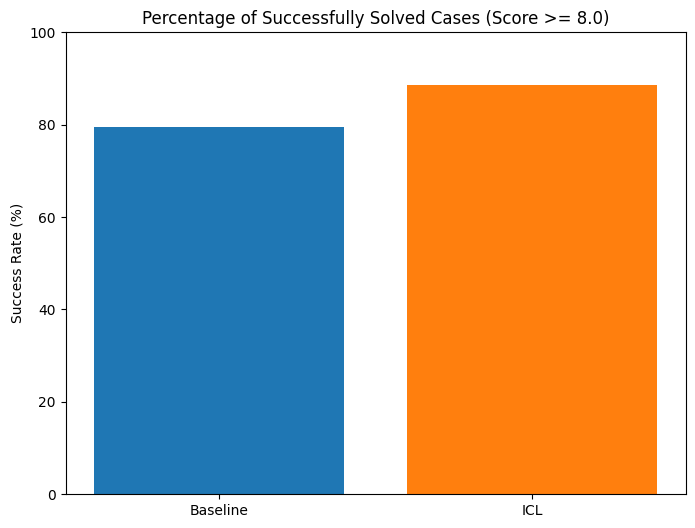


Success Rates Summary:
Baseline: 79.55% of cases successfully solved (score >= 8.0)
ICL: 88.64% of cases successfully solved (score >= 8.0)


In [13]:
# Then calculate success rates using the scores_df
success_rates = analyze_success_rates(scores_df)

# Display the success rates
print("\nSuccess Rates Summary:")
for method, rate in success_rates.items():
    print(f"{method}: {rate:.2f}% of cases successfully solved (score >= 8.0)")